In [1]:
import time as tm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, recall_score, classification_report
from sklearn.preprocessing import MinMaxScaler
# from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression, RidgeClassifier
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTENC
from collections import Counter
import shap as shap # feature importance plotting

N_JOBS = 7
N_FOLDS = 5
SEED = 42

In [2]:
df_train = pd.read_csv('train_features_8.csv')
df_test = pd.read_csv('test_features_8.csv')

In [3]:
X = df_train.drop(["id", "type"], axis = 1)
y = df_train["type"]

X_test = df_test.drop(["id", "type"], axis = 1)

In [4]:
CAT_FEATURES = [
              'education', 'id_org'
            ]
NUM_FEATURES = [
                'is_late_last', 'is_hooky_last', 'edu_middle_prof', 'has_boss',
                'has_sub', 'edu_middle', 'edu_primary_prof',
                'calls_weekday_sum', 'calls_weekend_sum', 'time_calls_weekday_sum', 'time_calls_weekend_sum',
                'call_weekday_count', 'call_weekend_count', 'time_calls_weekday_mean', 'time_calls_weekend_mean', 'dateNum_count',
                'is_delay_mean', 'is_late_mean', 'is_hooky_mean', 'is_delay_sum', 'is_late_sum', 'is_hooky_sum',
                'time_delay_sum', 'time_delay_mean', 'time_late_sum', 'time_late_mean', 'time_hooky_sum', 'time_hooky_mean',
                'edu_high', 'edu_training', 'count_subords',
                'task_count', 'task_wasted_days_sum', 'task_wasted_days_mean', 'task_wasted_count', 'task_wasted_fraction',
              ]

ALL_FEATURES = CAT_FEATURES + NUM_FEATURES

print(f"Count of features: {len(ALL_FEATURES)}")

Count of features: 38


In [5]:
X = X[ALL_FEATURES]
X_test = X_test[ALL_FEATURES]

In [6]:
print(Counter(y))
oversample = SMOTENC(categorical_features=[i for i in range(len(CAT_FEATURES))],
                     sampling_strategy={2: 298, 0: 250, 1: 200, 3: 150},
                     random_state=SEED)
X, y = oversample.fit_resample(X, y)
print(Counter(y))

Counter({2: 298, 0: 153, 1: 74, 3: 25})
Counter({2: 298, 0: 250, 1: 200, 3: 150})


In [7]:
scorer = make_scorer(recall_score, average = 'macro')

In [8]:
models = {
    # 'Logistic Regression': {
    #     'model': LogisticRegression(solver='saga', random_state=SEED),
    #     'params': {
    #         'penalty': ('l1', 'l2', 'elasticnet'),
    #         'tol': (1e-06, 1e-04),
    #     },
    # },
    # 'Ridge Classifier': {
    #     'model': RidgeClassifier(),
    #     'params': {
    #         'alpha': (0.1, 0.5, 1.0, 10, 25, 50, 100),
    #         'tol': (1e-06, 1e-04),
    #     },
    # },
    'RandomForestClassifier': {
        'model': RandomForestClassifier(n_jobs=N_JOBS, random_state=SEED),
        'params': {
            'n_estimators': (50, 100, 200),
            'max_depth': (None, 3, 5, 9),
        },
    },
    # 'Desicion Tree': {
    #     'model': DecisionTreeClassifier(random_state=SEED),
    #     'params': {
    #         'criterion': ('gini', 'log_loss'),
    #         'max_depth': (3, 4, 5, 6,),
    #         'min_samples_split': (2, 4, 6),
    #         'min_samples_leaf': (2,3)
    #     },
    # },
    'CatBoost': {
        'model': CatBoostClassifier(random_state=SEED, silent=True),
        'params': {
            # 'iterations': [500, 1000, 2000],
            'l2_leaf_reg': [0.5],
            # 'subsample': [0.9, 0.95, 0.99],
        },
    },
    # 'XGBoost': {
    #     'model': XGBClassifier(n_estimators=500, eval_metric=scorer, n_jobs=N_JOBS, random_state=SEED),
    #     'params': {
    #         # 'booster': ['gbtree', 'dart'],
    #         # 'eval_metric': ["mae"],
    #         # 'n_estimators': [200, 400, 1000, 2000, 5000],
    #         # 'max_depth': [3, 4, 5], #3,6
    #         # 'reg_alpha': [0.01, 0.1, 0.2, 0.5, 1, 5, 10, 50, 75, 100, 150, 200],
    #         # 'reg_lambda': [0.01, 0.1, 0.5, 1, 10, 100],
    #     },
    # },
}

In [9]:
ordinal_encoder = OrdinalEncoder()
X[CAT_FEATURES] = ordinal_encoder.fit_transform(X[CAT_FEATURES])

scaler = MinMaxScaler()
X[NUM_FEATURES] = scaler.fit_transform(X[NUM_FEATURES])

In [10]:
for model_name, m in models.items():
    print(model_name)
    model = m['model']
    params = m['params']
    print(params)

    start = tm.time()
    clf = GridSearchCV(
        model,
        params,
        cv=N_FOLDS,
        scoring=scorer,
        return_train_score=False,
        n_jobs=N_JOBS,
    )
    clf.fit(X, y)
    model = clf.best_estimator_
    cv_score = -clf.best_score_
    models[model_name]['predictor'] = model
    # test_metrics = eval_metrics(y_test, model.predict(X_test))
    print(clf.best_params_)
    print(f"cross-val: {-cv_score}")
    # for metric, value in test_metrics.items():
    #     logger.info(f"{metric}: {value}")
    print(f"Fit time: {(tm.time() - start):.0f}s\n")

RandomForestClassifier
{'n_estimators': (50, 100, 200), 'max_depth': (None, 3, 5, 9)}
{'max_depth': None, 'n_estimators': 200}
cross-val: 0.7623531073446328
Fit time: 16s

CatBoost
{'l2_leaf_reg': [0.5]}
{'l2_leaf_reg': 0.5}
cross-val: 0.7630466101694914
Fit time: 233s



## Validate

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [12]:
model = models['CatBoost']['predictor']
model.fit(X_train, y_train)

predictions_val = model.predict(X_val)

print(classification_report(y_val, predictions_val))

              precision    recall  f1-score   support

           0       0.59      0.62      0.60        52
           1       0.79      0.71      0.75        42
           2       0.56      0.58      0.57        57
           3       0.93      0.93      0.93        29

    accuracy                           0.68       180
   macro avg       0.72      0.71      0.71       180
weighted avg       0.68      0.68      0.68       180



In [13]:
model = models['RandomForestClassifier']['predictor']
model.fit(X_train, y_train)

predictions_val = model.predict(X_val)

print(classification_report(y_val, predictions_val))

              precision    recall  f1-score   support

           0       0.59      0.58      0.58        52
           1       0.82      0.67      0.74        42
           2       0.56      0.67      0.61        57
           3       0.89      0.83      0.86        29

    accuracy                           0.67       180
   macro avg       0.71      0.68      0.70       180
weighted avg       0.68      0.67      0.67       180



## Test

In [14]:
X_test[CAT_FEATURES] = ordinal_encoder.transform(X_test[CAT_FEATURES])
X_test[NUM_FEATURES] = scaler.transform(X_test[NUM_FEATURES])

In [15]:
# predictions = models['CatBoost']['predictor'].predict(X_test)

# df_test['type'] = predictions
# df_test['type'].value_counts()

In [16]:
# df_test[['id', 'type']].to_csv('test_16_1.csv', index=False)

#### Refit best model

In [17]:
model = models['CatBoost']['predictor']
model.fit(X, y)

predictions = model.predict(X_test)

df_test['type'] = predictions
df_test['type'].value_counts()

2    165
0     63
1     32
3      2
Name: type, dtype: int64

In [18]:
df_test[['id', 'type']].to_csv('test_17_x.csv', index=False)

#### Feature importance

In [19]:
feature_importance_df = pd.DataFrame(model.feature_importances_, index=X.columns)
feature_importance_df.sort_values(by=0, ascending=False)

,0
has_boss,8.524886
time_calls_weekday_mean,6.666910
task_wasted_fraction,4.661210
task_wasted_days_mean,4.386173
time_late_mean,4.206492
time_late_sum,4.079175
edu_high,3.969844
task_count,3.720441
id_org,3.525137
is_late_sum,3.331863


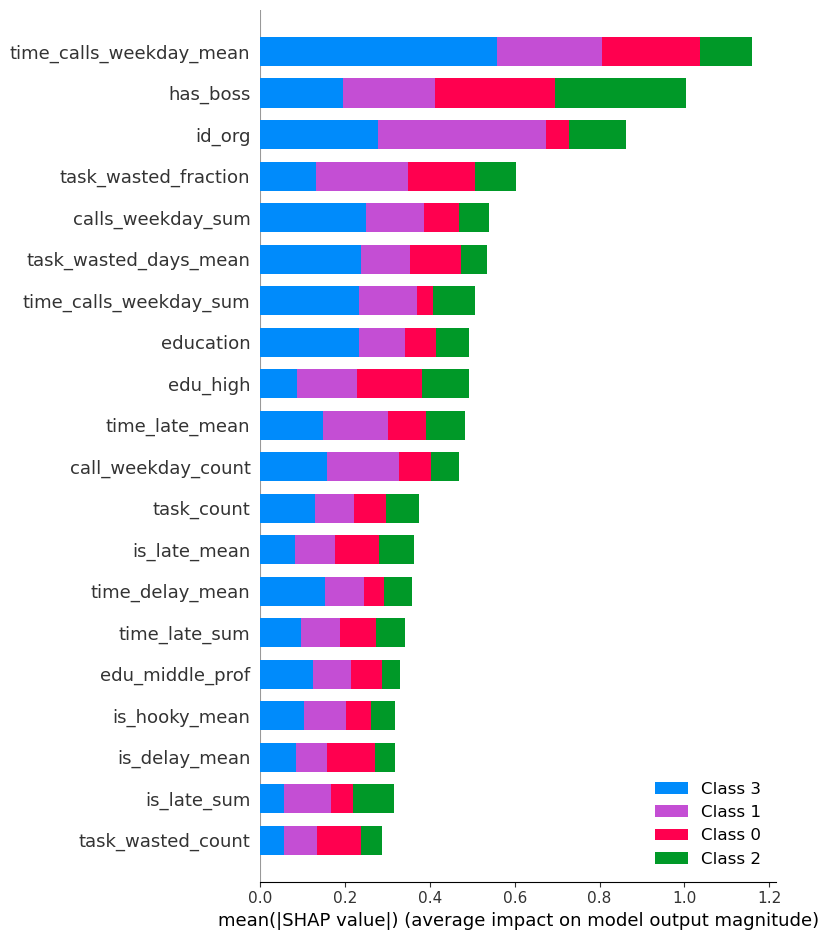

In [20]:
train_data = Pool(data=X,
                  label=y,
                  #cat_features=CAT_FEATURES
                 )
                 
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_data)
shap.summary_plot(shap_values, X_train, feature_names=ALL_FEATURES)

In [21]:
# predictions = models['XGBoost']['predictor'].predict(X_test)

# df_test['type'] = predictions

# df_test['type'].value_counts()

In [22]:
# df_test[['id', 'type']].to_csv('test_10.csv', index=False)